<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.14.03.Colab_LandCover_MODIS_500m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODIS Landcover
This notebook uses the MODIS (500-meter) land cover product over the period of 2001 to 2020. The output shows a land classification (17 classes) map for any selected year. This data can be found in the Google Earth Engine database as "MCD12Q1.006 MODIS Land Cover Type Yearly Global 500m". 

## Instructions for Execution

It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for the "MODIFY HERE" labels to modify the region of interest and the analysis year.

Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [ ]:
from odc_colab import populate_db
populate_db()

## Load the Data Cube Configuration and Import Utilities

In [1]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
import datacube
from odc_gee import earthengine
dc = earthengine.Datacube(app='MODIS_Landcover')

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Define the Extents of the Analysis and View
Select the center of an analysis region (lat_long) below. The size of the region (in degrees) that surrounds this center point is defined using the "box_size_deg" parameter. Users can select one of the sample regions or add a new region. Use the map below to zoom in-or-out to find other regions. Click on the map to view a Lat-Lon position. 

In [2]:
# MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Kumasi, Ghana 
lat_long = (6.7, -1.6)
box_size_deg = 0.50

# Calculates the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [3]:
# Define the time range of the dataset
time_range = ('2001', '2020')

In [4]:
# The code below renders a map that can be used to view the region.
display_map(latitude,longitude)

## Load the Dataset
Since the data uses a sinusoidal grid projection, we will convert to a common WGS84 UTM grid projection.

In [5]:
dataset = dc.load(product='modis_landcover_google',
                  time=time_range,measurements=['lc_type1'],
                  latitude=latitude, 
                  longitude=longitude,
                  output_crs='PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["false_easting",0],PARAMETER["false_northing",0],PARAMETER["longitude_of_center",0],PARAMETER["semi_major",6371007.181],PARAMETER["semi_minor",6371007.181],UNIT["m",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["SR-ORG","6974"]]',
                  resolution=(-463.312716527000021, 463.312716528000010))

In [6]:
# Show the dimensions of the dataset
# The latitude and longitude bounds are in pixels
# The time index is in years 
# The "data variables" data are the classifications
dataset

<xarray.Dataset>
Dimensions:      (time: 20, x: 120, y: 120)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-01 2002-01-01 ... 2020-01-01
  * y            (y) float64 7.684e+05 7.679e+05 ... 7.137e+05 7.133e+05
  * x            (x) float64 -2.046e+05 -2.041e+05 ... -1.499e+05 -1.494e+05
    spatial_ref  int32 0
Data variables:
    lc_type1     (time, y, x) uint8 9 9 9 9 9 9 9 9 9 9 ... 2 2 8 8 2 2 8 8 8 8
Attributes:
    crs:           PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984"...
    grid_mapping:  spatial_ref

In [7]:
# Show data layer indices and corresponding years
# These indices will be used later to view the classification data
pd.DataFrame(list(dataset.time.values.astype('datetime64[Y]').astype(int)+1970),columns=['Year'])

,Year
0,2001
1,2002
2,2003
3,2004
4,2005
5,2006
6,2007
7,2008
8,2009
9,2010


### Create classification labels
The product comes with `flags_definition` metadata.

In [8]:
stac_metadata = dc.get_stac_metadata('MODIS/006/MCD12Q1')

flags = {0: 'nodata'}
flags.update({int(list(val['values'].keys())[1]): key\
         for key, val in dataset['lc_type1'].flags_definition.items()})

labels = {0: dict(color='#000000', flag=flags[0])}
labels.update({_class['value']: dict(color=f'#{_class["color"]}',
                                flag=flags[_class['value']])\
          for _class in stac_metadata['summaries']['eo:bands'][0]['gee:classes']})
colors = [label['color'] for label in labels.values()]

### Create color map
Create the cmap from colors/labels and offset ticks to center everything.

In [9]:
cmap = ListedColormap([label['color'] for label in labels.values()])
norm = BoundaryNorm(list(labels.keys())+[18], cmap.N+1, extend='max')
ticks = list(np.mean((list(list(labels.keys())+[18])[i+1], val)) for i, val in enumerate(list(labels.keys())))

### Plot the classification data

In [10]:
# MODIFY HERE

# Choose a single year by its index (listed above)
year_to_show = 19

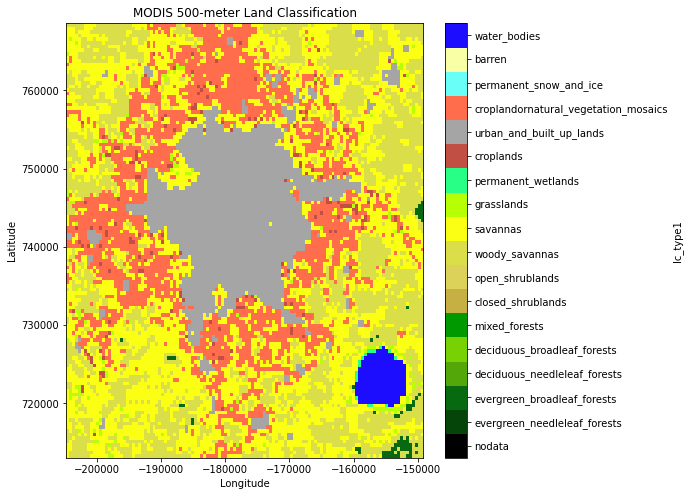

In [11]:
aspect = dataset.dims['x']/dataset.dims['y']
fig = dataset['lc_type1'].isel(time=year_to_show).plot.imshow(cmap=cmap, size=8, norm=norm,
                                                     cbar_kwargs=dict(ticks=ticks),aspect=aspect)

cbar = fig.colorbar
cbar.ax.set_yticklabels(labels=[label['flag'] for label in labels.values()])
plt.title('MODIS 500-meter Land Classification')
plt.xlabel("X (meter)")
plt.ylabel("Y (meter)")
plt.show()

### Statistics

In [12]:
print('\033[1;4mTotal number of pixels for each classification.\033[0m')
for val, label in labels.items():
    print(f'{label["flag"]}: {np.sum(dataset.lc_type1.isel(time=0).values == val)}')
    
print('\n\033[1;4mPercent of total pixel area.\033[0m')
for val, label in labels.items():
    area = np.sum(dataset.lc_type1.isel(time=0).values == val)\
           /dataset.lc_type1.isel(time=0).size * 100
    print(f'{label["flag"]}: {round(area, 2)}%')

Total number of pixels for each classification.
nodata: 0
evergreen_needleleaf_forests: 0
evergreen_broadleaf_forests: 82
deciduous_needleleaf_forests: 0
deciduous_broadleaf_forests: 0
mixed_forests: 0
closed_shrublands: 0
open_shrublands: 0
woody_savannas: 802
savannas: 7074
grasslands: 153
permanent_wetlands: 14
croplands: 28
urban_and_built_up_lands: 1705
croplandornatural_vegetation_mosaics: 4327
permanent_snow_and_ice: 0
barren: 0
water_bodies: 215

Percent of total pixel area.
nodata: 0.0%
evergreen_needleleaf_forests: 0.0%
evergreen_broadleaf_forests: 0.57%
deciduous_needleleaf_forests: 0.0%
deciduous_broadleaf_forests: 0.0%
mixed_forests: 0.0%
closed_shrublands: 0.0%
open_shrublands: 0.0%
woody_savannas: 5.57%
savannas: 49.12%
grasslands: 1.06%
permanent_wetlands: 0.1%
croplands: 0.19%
urban_and_built_up_lands: 11.84%
croplandornatural_vegetation_mosaics: 30.05%
permanent_snow_and_ice: 0.0%
barren: 0.0%
water_bodies: 1.49%
